## Use Benfords Law to idenfity vendor payments that might be fraudulent

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
files = glob.glob('data/cleaned_data/*.csv')

payments = pd.concat([pd.read_csv(f, dtype={'commitmt_item_name': 'str', 'dept._descrptn': 'str', 'vendor_name': 'str'}) \
                      for f in files], sort=True)

In [14]:
payments.dtypes

check/payment_date     object
commitmt_item_name     object
dept._descrptn         object
invoice_net_amt       float64
vendor_name            object
leading_digit          object
dtype: object

In [9]:
payments.head()

,check/payment_date,commitmt_item_name,dept._descrptn,invoice_net_amt,vendor_name,leading_digit
0,2014-01-02,Inventories,Street Transportation,-34.78,3M COMPANY,-
1,2014-01-02,Inventories,Street Transportation,-69.55,3M COMPANY,-
2,2014-01-02,Inventories,Street Transportation,-77.00,3M COMPANY,-
3,2014-01-02,Inventories,Public Works,0.01,AGS SAFETY & SUPPLY,0
4,2014-01-02,Inventories,Police,-0.79,AMERICAN EUROCOPTER CORPORATION,-


In [6]:
# benford's law guidlines
benfords_law = pd.DataFrame(
    {'Leading_Digit':[1,2,3,4,5,6,7,8,9],
     'Benfords_Percent':[30.1,17.60,12.50,9.70,7.90,6.70,5.80,5.10,4.60]}
    )

In [7]:
benfords_law

,Leading_Digit,Benfords_Percent
0,1,30.1
1,2,17.6
2,3,12.5
3,4,9.7
4,5,7.9
5,6,6.7
6,7,5.8
7,8,5.1
8,9,4.6


In [8]:
# extract leading digit from vendor payments
payments['leading_digit'] = payments['invoice_net_amt'].apply(lambda x: str(x)[0])

In [17]:
# exclude payments with other than positive payment amounts
payments = payments[(payments['leading_digit'] != '-') &
         (payments['leading_digit'] != '0')]

In [19]:
# exclude vendors with less than 50 payments
at_least_50 = payments.groupby('vendor_name').filter(lambda x: x['invoice_net_amt'].count() >= 50)


In [21]:
# how many vendors have at least 50 payments
at_least_50['vendor_name'].nunique()

2286

In [26]:
vendor_leading_digit = at_least_50.groupby(['vendor_name', 'leading_digit']).size()

vendor_leading_digit.head(20)

vendor_name                    leading_digit
1 N 10 INC                     1                46
                               2                 8
                               3                 3
                               4                43
                               5                 5
                               6                 3
                               7                 1
                               9                 3
1 STOP ELECTRONICS CENTER INC  1                79
                               2                54
                               3                43
                               4                63
                               5                36
                               6                60
                               7                13
                               8                 7
                               9                15
1-800-RADIATOR & A/C           1                54
                               2     

In [28]:
vendor_leading_digit_percent = vendor_leading_digit.groupby(level=0) \
    .apply(lambda x: 100 * x / float(x.sum())).reset_index()

In [30]:
vendor_leading_digit_percent.iloc[:,2].head()

0    41.071429
1     7.142857
2     2.678571
3    38.392857
4     4.464286
Name: 0, dtype: float64

In [ ]:
vendor_leading_digit_percent.shape

NameError: name 'matplotlib' is not defined

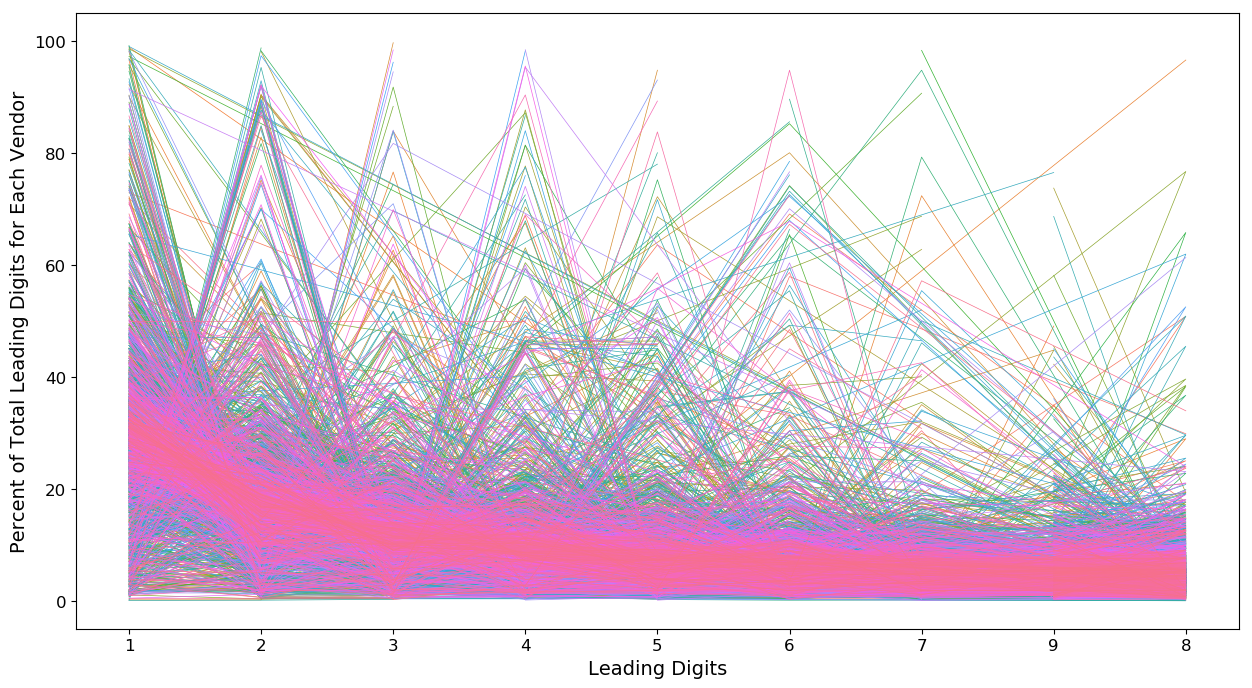

In [31]:
plt.style.use('default')

fig = plt.figure(figsize=(15, 8))
ax = sns.lineplot(x='leading_digit', \
                  y=vendor_leading_digit_percent.iloc[:,2], \
                  hue="vendor_name", \
                  data=vendor_leading_digit_percent, \
                  linewidth=.5, )

# plt.title("Leading Digit Frequencies for Vendors With At Least 50 Payments",fontsize=16)
plt.xlabel("Leading Digits",fontsize=14)
plt.ylabel("Percent of Total Leading Digits for Each Vendor",fontsize=14)
plt.tick_params(labelsize=12)
ax.get_legend().remove()

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(5))

# plt.savefig("visualizations/Leading Digit Frequencies for Vendors With At Least 50 Payments.png")